In [12]:
# compare icesat-2 data to ArcticDEM

import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import tarfile
import re
import uuid
import osgeo.gdal 

%matplotlib inline

# load ArcticDEM tiles

# Tyler Sutterley
#-- PURPOSE: read DEM tile file from gzipped tar files
def read_DEM_file(elevation_file):
    #-- open file with tarfile (read)
    tar = tarfile.open(name=elevation_file, mode='r:gz')
    #-- find dem geotiff file within tar file
    member, = [m for m in tar.getmembers() if re.search('dem\.tif',m.name)]
    #-- use GDAL memory-mapped file to read dem
    mmap_name = "/vsimem/{0}".format(uuid.uuid4().hex)
    osgeo.gdal.FileFromMemBuffer(mmap_name, tar.extractfile(member).read())
    ds = osgeo.gdal.Open(mmap_name)
    #-- read data matrix
    im = ds.GetRasterBand(1).ReadAsArray()
    fill_value = ds.GetRasterBand(1).GetNoDataValue()
    #-- get dimensions
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    #-- create mask for finding invalid values
    mask = np.zeros((ysize,xsize),dtype=np.bool)
    indy,indx = np.nonzero(im == fill_value)
    mask[indy,indx] = True
    #-- get geotiff info
    info_geotiff = ds.GetGeoTransform()
    #-- calculate image extents
    xmin = info_geotiff[0]
    ymax = info_geotiff[3]
    xmax = xmin + (xsize-1)*info_geotiff[1]
    ymin = ymax + (ysize-1)*info_geotiff[5]
    #-- close files
    ds = None
    osgeo.gdal.Unlink(mmap_name)
    tar.close()
    #-- create image x and y arrays
    xi = np.arange(xmin,xmax+info_geotiff[1],info_geotiff[1])
    yi = np.arange(ymax,ymin+info_geotiff[5],info_geotiff[5])
    #-- return values (flip y values to be monotonically increasing)
    return (im[::-1,:],mask[::-1,:],fill_value,xi,yi[::-1])


In [13]:
(im,mask,fill_value, east, north)=read_DEM_file('/home/jovyan/glaciersat2/arcticDEM/40_06_1_1_2m_v3.0.tar.gz')



# load Icesat-2 segments

# calculate and show changes

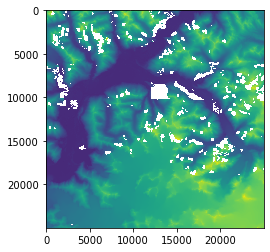

In [16]:
im = np.ma.array(im, mask=mask)
plt.imshow(im)
plt.show()


In [17]:
# load Icesat-2 segments
!wget http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/indexes/ArcticDEM_Tile_Index_Rel7.zip
!mv ArcticDEM_Tile_Index_Rel7.zip /home/jovyan/glaciersat2/arcticDEM/


--2019-06-19 00:45:28--  http://data.pgc.umn.edu/elev/dem/setsm/ArcticDEM/indexes/ArcticDEM_Tile_Index_Rel7.zip
Resolving data.pgc.umn.edu (data.pgc.umn.edu)... 134.84.212.106
Connecting to data.pgc.umn.edu (data.pgc.umn.edu)|134.84.212.106|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538740 (526K) [application/zip]
Saving to: ‘ArcticDEM_Tile_Index_Rel7.zip’

ArcticDEM_Tile_Inde 100%[===================>] 526.11K  2.64MB/s    in 0.2s    

2019-06-19 00:45:28 (2.64 MB/s) - ‘ArcticDEM_Tile_Index_Rel7.zip’ saved [538740/538740]



In [21]:
#-- PURPOSE: read zip file containing index shapefiles for finding DEM tiles
# function from T. Sutterley


def read_DEM_index(elevation_index_file, HEM):
    #-- extract zip file with shapefile index
    zs = zipfile.ZipFile(elevation_index_file)
    dbf,prj,shp,shx = [io.BytesIO(zs.read(s)) for s in sorted(zs.namelist())]
    #-- read the shapefile and extract entities
    shape_input = shapefile.Reader(dbf=dbf,prj=prj,shp=shp,shx=shx)
    shape_entities = shape_input.shapes()
    shape_attributes = shape_input.records()
    shape_field_names = [f[0] for f in shape_input.fields[1:]]
    #-- extract attribute indice for DEM tile (REMA) or objectid (ArcticDEM)
    if (HEM == 'S'):
        #-- REMA index file attributes:
        #-- name: DEM mosaic name for tile (file name without suffix)
        #-- tile: DEM tile identifier (IMy_IMx)
        #-- nd_value: fill value for elements with no data
        #-- resolution: DEM horizontal spatial resolution (meters)
        #-- creationda: creation date
        #-- raster: (empty)
        #-- fileurl: link to file on PGC server
        #-- spec_type: specific type (DEM)
        #-- qual: density of scenes within tile (0 to 1)
        #-- reg_src: DEM registration source (ICESat or neighbor align)
        #-- num_gcps: number of ground control points
        #-- meanresz: mean vertical residual (meters)
        #-- active: (1)
        #-- qc: (2)
        #-- rel_ver: release version
        #-- num_comp: number of components
        #-- st_area_sh: tile area (meters^2)
        #-- st_length_: perimeter length of tile (meters)
        ind, = [i for i,f in enumerate(shape_field_names) if (f == 'tile')]
    elif (HEM == 'N'):
        #-- ArcticDEM index file attributes:
        #-- objectid: DEM tile object identifier for sub-tile
        #-- name: DEM mosaic name for sub-tile (file name without suffix)
        #-- tile: DEM tile identifier (IMy_IMx) (non-unique for sub-tiles)
        #-- nd_value: fill value for elements with no data
        #-- resolution: DEM horizontal spatial resolution (meters)
        #-- creationda: creation date
        #-- raster: (empty)
        #-- fileurl: link to file on PGC server
        #-- spec_type: specific type (DEM)
        #-- qual: density of scenes within tile (0 to 1)
        #-- reg_src: DEM registration source (ICESat or neighbor align)
        #-- num_gcps: number of ground control points
        #-- meanresz: mean vertical residual (meters)
        #-- active: (1)
        #-- qc: (2)
        #-- rel_ver: release version
        #-- num_comp: number of components
        #-- st_area_sh: tile area (meters^2)
        #-- st_length_: perimeter length of tile (meters)
        ind, = [i for i,f in enumerate(shape_field_names) if (f == 'objectid')]
    #-- create python dictionary for each polygon object
    poly_dict = {}
    attrs_dict = {}
    #-- extract the entities and assign by tile name
    for i,ent in enumerate(shape_entities):
        #-- name or objectid of tile
        tile = str(shape_attributes[i][ind])
        #-- extract attributes and assign by tile
        attrs_dict[tile] = {}
        for j,field in enumerate(shape_field_names):
            attrs_dict[tile][field] = shape_attributes[i][j]
        #-- extract Polar Stereographic coordinates for entity
        points = np.array(ent.points)
        poly_obj = Polygon(list(zip(points[:,0], points[:,1])))
        #-- Valid Polygon may not possess overlapping exterior or interior rings
        if (not poly_obj.is_valid):
            poly_obj = poly_obj.buffer(0)
        poly_dict[tile] = poly_obj
    #-- close the zipfile
    zs.close()
    #-- return the dictionaries of polygon objects and attributes
    return poly_dict,attrs_dict


In [ ]:
poly_dict, attrs_dict = read_DEM_index('/home/jovyan/glaciersat2/arcticDEM/')